## Modelos base

### Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer, recall_score
from skopt import BayesSearchCV
from skopt.space import Categorical, Real
import numpy as np
from sklearn.exceptions import ConvergenceWarning

#Estilizar conteúdo
warnings.filterwarnings("ignore", category = ConvergenceWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

#Matriz de confusão

def exibe_matrizes_confusao(dicio_matrizes):
    fig, axn = plt.subplots(1, 4,  sharey=True, figsize=(10, 2))
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.5)
    for i, ax in enumerate(axn.flat):
        k = list(dicio_matrizes)[i]

        ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=8)
        ax.set_title(k,fontsize=8)

        sns.heatmap(dicio_matrizes[k], ax=ax,cbar=i==4)
        sns.heatmap(dicio_matrizes[k], annot=True, fmt="d", cmap="Blues", ax=ax, cbar=i==4,
                xticklabels=['Não Reconhecido', 'Reconhecido'],
                yticklabels=['Não Reconhecido', 'Reconhecido'],)

### Bases de dados

In [2]:
df1 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2010_2017_modelo1.csv",
    sep=';',
    decimal=',',
)

df2 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2010_2017_modelo2.csv",
    sep=';',
    decimal=',',
)

df3 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo1.csv",
    sep=';',
    decimal=',',
)

df4 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo2.csv",
    sep=';',
    decimal=',',
)

# Remove nulos
df2 = df2[df2['DensidadePop'].notnull()]
df4 = df4[df4['DensidadePop'].notnull()]
df3 = df3[df3['DOMICILIO_AREARURAL'].notnull()]
df4 = df4[df4['DOMICILIO_AREARURAL'].notnull()]

# Criar dicionário python com uma descrição para cada conjunto de dados
dict_dfs = {
    "Modelo 1 - 2010 a 2017 - agregado": df1,
    "Modelo 2 - 2010 a 2017 - desagregado": df2,
    "Modelo 3 - 2018 a 2024 - agregado": df3,
    "Modelo 4 - 2018 a 2024 - desagregado": df4,
}

print("Dimensões base de dados variáveis agregadas 2010-2017: ", df1.shape)
print("Dimensões base de dados variáveis agregadas 2018-2024: ", df2.shape)
print("Dimensões base de dados variáveis desagregadas 2010-2017: ",df3.shape)
print("Dimensões base de dados variáveis desagregadas 2018-2024: ",df4.shape)

Dimensões base de dados variáveis agregadas 2010-2017:  (13047, 56)
Dimensões base de dados variáveis agregadas 2018-2024:  (8600, 117)
Dimensões base de dados variáveis desagregadas 2010-2017:  (13170, 61)
Dimensões base de dados variáveis desagregadas 2018-2024:  (8275, 122)


### Modelos de regressão logística

#### Modelo base

Classification report para Modelo 1 - 2010 a 2017 - agregado: 



,precision,recall,f1-score,support
Reconhecido,0.286,0.034,0.061,234.000
Não reconhecido,0.912,0.992,0.950,2376.000
accuracy,0.906,0.906,0.906,0.906
macro avg,0.599,0.513,0.506,2610.000
weighted avg,0.856,0.906,0.871,2610.000


Matriz de confusão para Modelo 1 - 2010 a 2017 - agregado: 



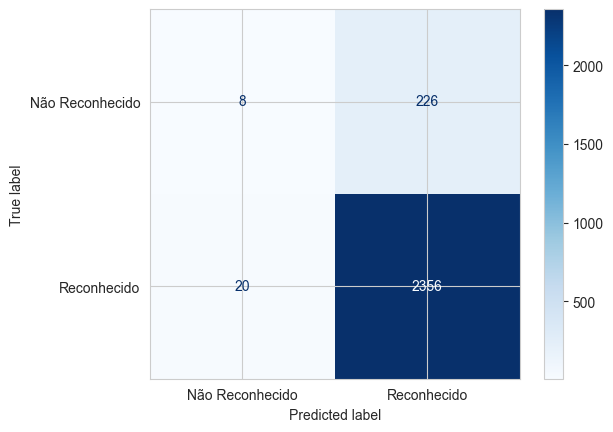

Classification report para Modelo 2 - 2010 a 2017 - desagregado: 



,precision,recall,f1-score,support
Reconhecido,0.167,0.028,0.048,144.000
Não reconhecido,0.917,0.987,0.951,1576.000
accuracy,0.907,0.907,0.907,0.907
macro avg,0.542,0.508,0.499,1720.000
weighted avg,0.855,0.907,0.875,1720.000


Matriz de confusão para Modelo 2 - 2010 a 2017 - desagregado: 



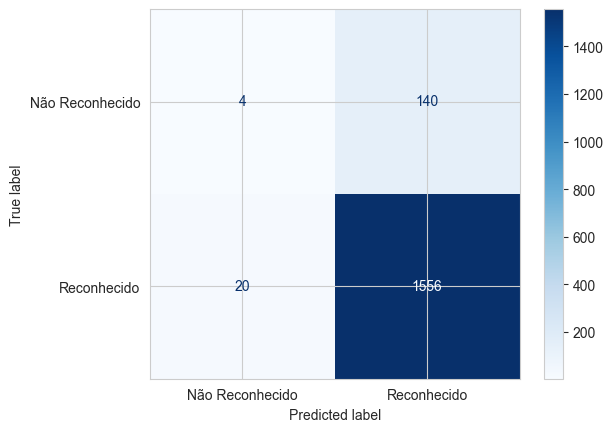

Classification report para Modelo 3 - 2018 a 2024 - agregado: 



,precision,recall,f1-score,support
Reconhecido,0.750,0.056,0.103,216.000
Não reconhecido,0.922,0.998,0.959,2418.000
accuracy,0.921,0.921,0.921,0.921
macro avg,0.836,0.527,0.531,2634.000
weighted avg,0.908,0.921,0.889,2634.000


Matriz de confusão para Modelo 3 - 2018 a 2024 - agregado: 



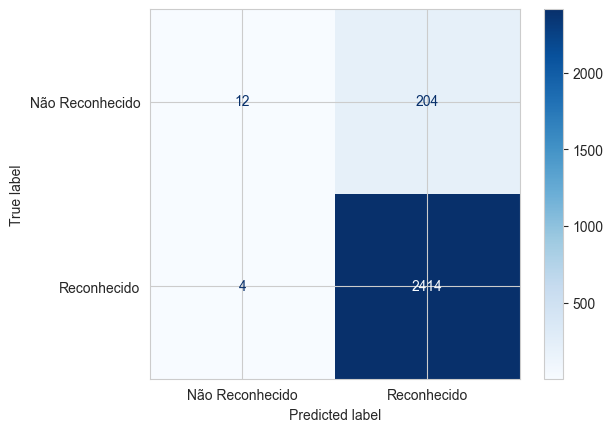

Classification report para Modelo 4 - 2018 a 2024 - desagregado: 



,precision,recall,f1-score,support
Reconhecido,0.237,0.128,0.166,149.000
Não reconhecido,0.917,0.959,0.938,1506.000
accuracy,0.885,0.885,0.885,0.885
macro avg,0.577,0.544,0.552,1655.000
weighted avg,0.856,0.885,0.868,1655.000


Matriz de confusão para Modelo 4 - 2018 a 2024 - desagregado: 



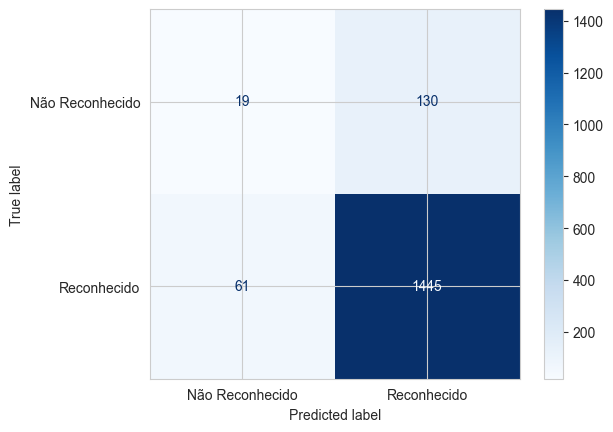

In [3]:
cf_matrix = dict.fromkeys(dict_dfs.keys())

for desc_modelo, df in dict_dfs.items():

    # Separa treino/teste
    X = df.drop("Status", axis=1)
    y = df["Status"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pipeline
    pipeline = Pipeline(
        steps=[
            ("robust_scaler", RobustScaler()),
            ("log_reg", LogisticRegression(max_iter=1000, random_state=42, solver="liblinear",
                                           dual=False)),
        ]
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Classification report como DataFrame
    df_cr = pd.DataFrame(
        metrics.classification_report(y_test, y_pred, output_dict=True, target_names=["Reconhecido", "Não reconhecido"])
    ).transpose()  # Transpor para uma melhor visualização

    # Aplicar o estilo personalizado
    df_cr_styled = estilo_tabelas(df_cr)

    # Exibir o classification report estilizado
    print(f'Classification report para {desc_modelo}: \n')
    display(df_cr_styled)  # Usando display() para mostrar o estilo no ambiente Jupyter/Notebooks

    # Confusion Matrix usando ConfusionMatrixDisplay.from_estimator
    print(f'Matriz de confusão para {desc_modelo}: \n')
    ConfusionMatrixDisplay.from_estimator(
        pipeline, X_test, y_test, values_format='d', cmap='Blues', display_labels=['Não Reconhecido', 'Reconhecido']
    )
    plt.show()  # Mostrar a matriz de confusão